In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

import numpy as np
import pathlib
import os
import datetime

from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [2]:
import pathlib
dataset_dir = "./EuroSAT_RGB/"
data_dir = pathlib.Path(dataset_dir).with_suffix('')

### Prepare dataset for training and validation

In [3]:
batch_size = 32
img_height = 64
img_width = 64

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [6]:
num_classes = len(train_ds.class_names)
print(num_classes)
train_ds.class_names

10


['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [7]:
for example in test_ds.take(1):
    print(example[0].shape, example[1].shape)
for example in train_ds.take(1):
    print(example[0].shape, example[1].shape)

(32, 64, 64, 3) (32, 10)
(32, 64, 64, 3) (32, 10)


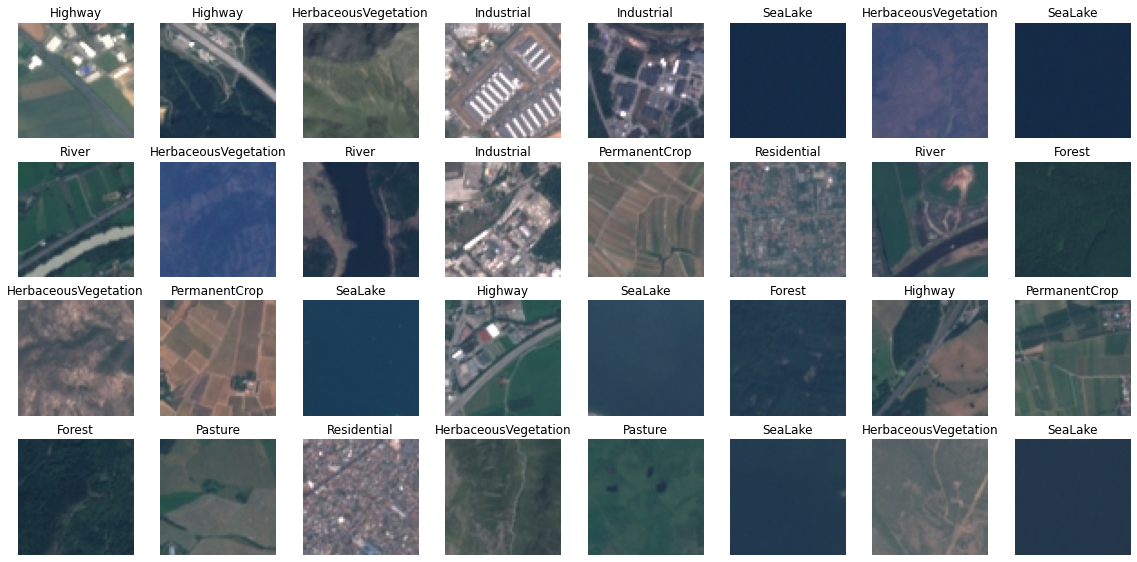

In [8]:
batch = next(iter(train_ds))
plt.figure(figsize=(20, 20))
for img in range(32):
    ax = plt.subplot(8, 8, img + 1)
    plt.imshow(batch[0][img].numpy().astype("uint32"))
    plt.title(train_ds.class_names[tf.argmax(batch[1][img].numpy())]) # index based labels from class_names
    plt.axis('off')

### Run model

#### Pre-trained model

In [9]:
imagenet_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/classification/5", trainable=True)

model_trained = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    imagenet_model,
    tf.keras.layers.Dense(num_classes, activation="softmax")])

model_trained.build([None, 64, 64, 3])
model_trained.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes)])
model_trained.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1001)              4254889   
_________________________________________________________________
dense (Dense)                (None, 10)                10020     
Total params: 4,264,909
Trainable params: 4,243,021
Non-trainable params: 21,888
_________________________________________________________________


In [10]:
history_trained = model_trained.fit(train_ds, validation_data=test_ds, epochs=3)
#history_trained.history

Epoch 1/3
675/675 [==============================] - 93s 136ms/step - loss: 1.4661 - accuracy: 0.8430 - f1_score: 0.8406 - val_loss: 1.4199 - val_accuracy: 0.8913 - val_f1_score: 0.8875
Epoch 2/3
675/675 [==============================] - 96s 143ms/step - loss: 0.6660 - accuracy: 0.9026 - f1_score: 0.9013 - val_loss: 0.4684 - val_accuracy: 0.9280 - val_f1_score: 0.9242
Epoch 3/3
675/675 [==============================] - 95s 140ms/step - loss: 0.4435 - accuracy: 0.9380 - f1_score: 0.9370 - val_loss: 0.3541 - val_accuracy: 0.9593 - val_f1_score: 0.9576


#### Using feature extractor

In [11]:
features_extractor = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2", trainable=True)

model_with_extractor = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  features_extractor,
  tf.keras.layers.Dense(num_classes, activation="softmax")])

model_with_extractor.build([None, 64, 64, 3]) # input shape
model_with_extractor.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", tfa.metrics.F1Score(num_classes)])  
model_with_extractor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 1280)              117746848 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 117,759,658
Trainable params: 117,247,082
Non-trainable params: 512,576
_________________________________________________________________


In [12]:
history_with_extractor = model_with_extractor.fit(train_ds, validation_data=test_ds, epochs=1)
#history_with_extractor.history

675/675 [==============================] - 1565s 2s/step - loss: 0.4072 - accuracy: 0.8774 - f1_score: 0.8746 - val_loss: 0.1709 - val_accuracy: 0.9315 - val_f1_score: 0.9332


### Using custom model

In [20]:
model_custom = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_custom.build([None, 64, 64, 3]) # input shape
model_custom.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', tfa.metrics.F1Score(num_classes)])
model_custom.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)         

In [21]:
history_custom = model_custom.fit(train_ds, validation_data=test_ds, epochs=15)
#history_custom.history

Epoch 1/15
675/675 [==============================] - 17s 25ms/step - loss: 1.2949 - accuracy: 0.5137 - f1_score: 0.4948 - val_loss: 0.9635 - val_accuracy: 0.6559 - val_f1_score: 0.6135
Epoch 2/15
675/675 [==============================] - 17s 25ms/step - loss: 0.8749 - accuracy: 0.6808 - f1_score: 0.6693 - val_loss: 0.6968 - val_accuracy: 0.7570 - val_f1_score: 0.7499
Epoch 3/15
675/675 [==============================] - 17s 26ms/step - loss: 0.7292 - accuracy: 0.7341 - f1_score: 0.7252 - val_loss: 0.9467 - val_accuracy: 0.6402 - val_f1_score: 0.6091
Epoch 4/15
675/675 [==============================] - 17s 25ms/step - loss: 0.6433 - accuracy: 0.7652 - f1_score: 0.7560 - val_loss: 0.6466 - val_accuracy: 0.7707 - val_f1_score: 0.7579
Epoch 5/15
675/675 [==============================] - 17s 26ms/step - loss: 0.5947 - accuracy: 0.7890 - f1_score: 0.7815 - val_loss: 0.6136 - val_accuracy: 0.7848 - val_f1_score: 0.7706
Epoch 6/15
675/675 [==============================] - 17s 25ms/step - 

### Prediction

#### Set model for evaluation

In [22]:
# Choose one of the models to be evaluated

model = model_trained
# OR
#model = model_with_extractor
# OR
#model = model_custom

#### Accuracy

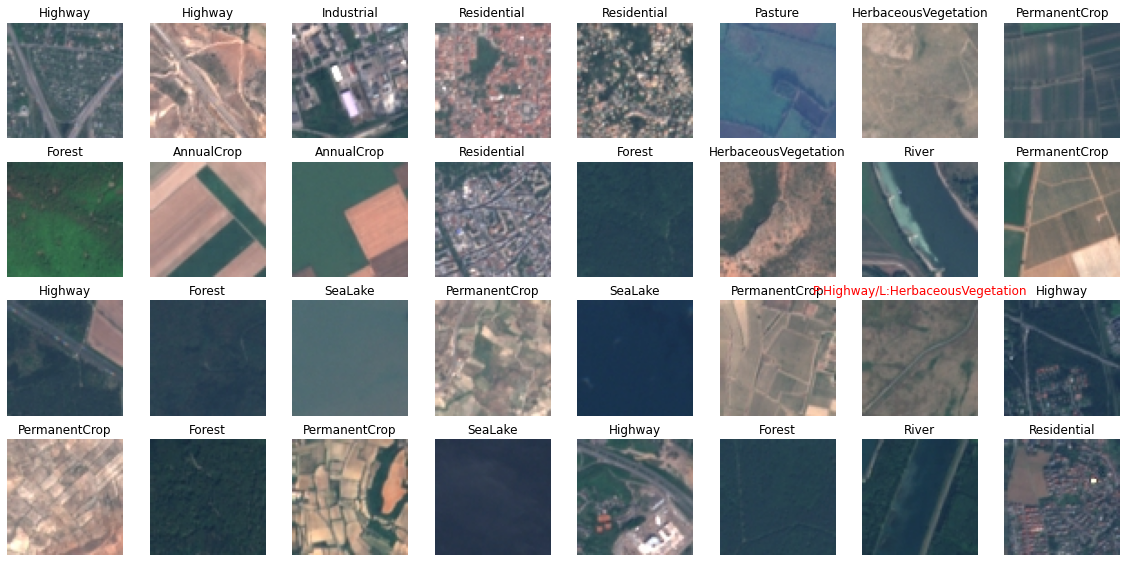

In [23]:
batch = next(iter(test_ds))
predictions = model.predict(batch[0])
predictions = np.argmax(predictions, axis=1)
labels=np.argmax(batch[1], axis=1)

plt.figure(figsize=(20, 20))
for n in range(32):
    ax = plt.subplot(8, 8, n + 1)
    plt.imshow(batch[0][n].numpy().astype("uint32"))
    if predictions[n] == labels[n]:
        plt.title(f"{test_ds.class_names[predictions[n]]}", color='black')
    else:
        plt.title(f"P:{test_ds.class_names[predictions[n]]}/L:{test_ds.class_names[labels[n]]}", color='red')
    plt.axis('off')

#### Softmax

In [24]:
batch = next(iter(test_ds))
predictions = model.predict(batch[0])
labels=np.argmax(batch[1], axis=1)

In [25]:
def print_sample(idx):
    plt.figure(figsize=(7, 7))
    plt.imshow(batch[0][idx].numpy().astype("uint32"));
    plt.axis('off');
    pred_lst = predictions[idx].tolist()
    print(f"LABEL")
    print(f"   {test_ds.class_names[labels[idx]]}")
    print('--------')
    print('SOFTMAX')    
    dct={test_ds.class_names[i]:"{:2.5f}".format(pred_lst[i]) for i in range(len(pred_lst))}
    for d in dct:
        print(f"   {d}:{dct[d]}")

################
LABEL
   Industrial
--------
SOFTMAX
   AnnualCrop:0.00000
   Forest:0.00000
   HerbaceousVegetation:0.00000
   Highway:0.00000
   Industrial:1.00000
   Pasture:0.00000
   PermanentCrop:0.00000
   Residential:0.00000
   River:0.00000
   SeaLake:0.00000


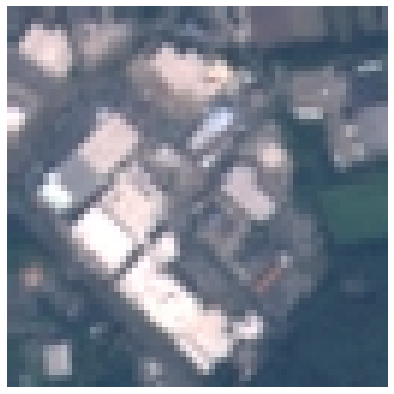

################
LABEL
   River
--------
SOFTMAX
   AnnualCrop:0.00018
   Forest:0.00002
   HerbaceousVegetation:0.00000
   Highway:0.00036
   Industrial:0.00001
   Pasture:0.00003
   PermanentCrop:0.00000
   Residential:0.00000
   River:0.99939
   SeaLake:0.00001


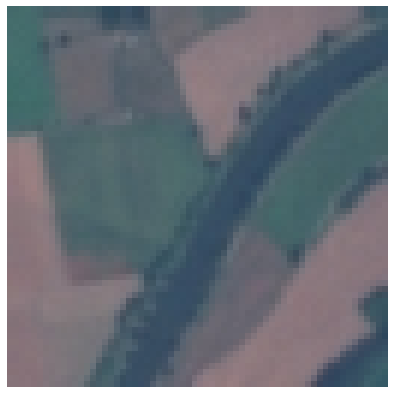

################
LABEL
   PermanentCrop
--------
SOFTMAX
   AnnualCrop:0.00000
   Forest:0.00000
   HerbaceousVegetation:0.00000
   Highway:0.00000
   Industrial:0.00000
   Pasture:0.00000
   PermanentCrop:1.00000
   Residential:0.00000
   River:0.00000
   SeaLake:0.00000


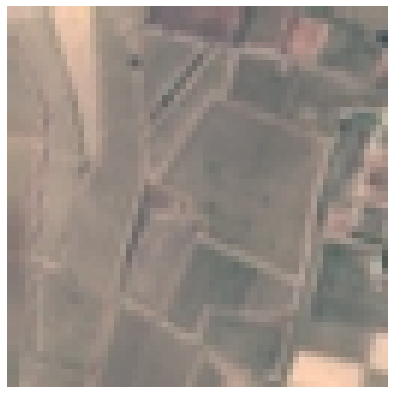

################
LABEL
   PermanentCrop
--------
SOFTMAX
   AnnualCrop:0.00024
   Forest:0.00001
   HerbaceousVegetation:0.00216
   Highway:0.00002
   Industrial:0.00011
   Pasture:0.00002
   PermanentCrop:0.99714
   Residential:0.00029
   River:0.00001
   SeaLake:0.00001


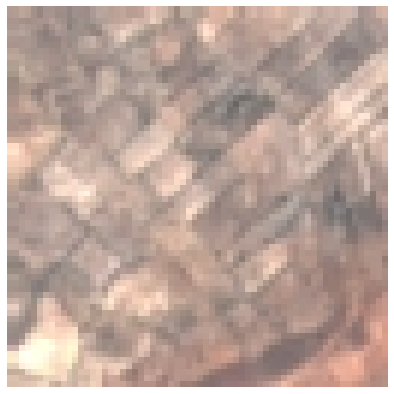

################
LABEL
   AnnualCrop
--------
SOFTMAX
   AnnualCrop:0.99941
   Forest:0.00011
   HerbaceousVegetation:0.00000
   Highway:0.00001
   Industrial:0.00000
   Pasture:0.00005
   PermanentCrop:0.00001
   Residential:0.00000
   River:0.00028
   SeaLake:0.00013


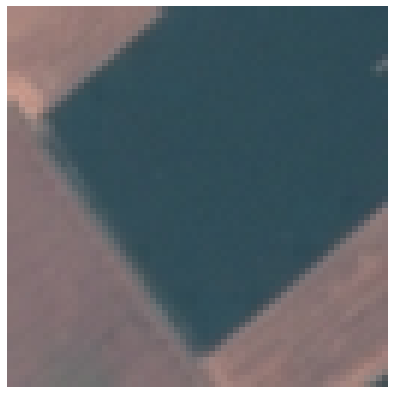

################
LABEL
   Forest
--------
SOFTMAX
   AnnualCrop:0.00000
   Forest:0.99929
   HerbaceousVegetation:0.00068
   Highway:0.00000
   Industrial:0.00000
   Pasture:0.00001
   PermanentCrop:0.00000
   Residential:0.00000
   River:0.00000
   SeaLake:0.00001


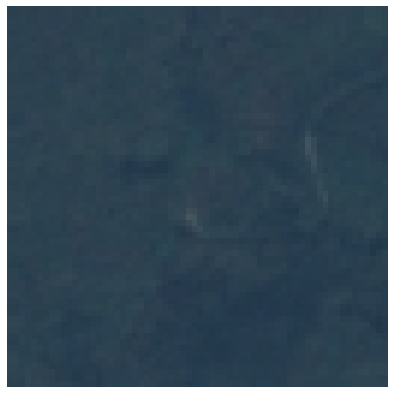

################
LABEL
   River
--------
SOFTMAX
   AnnualCrop:0.00308
   Forest:0.01275
   HerbaceousVegetation:0.14013
   Highway:0.00104
   Industrial:0.00028
   Pasture:0.00533
   PermanentCrop:0.00513
   Residential:0.00139
   River:0.82434
   SeaLake:0.00652


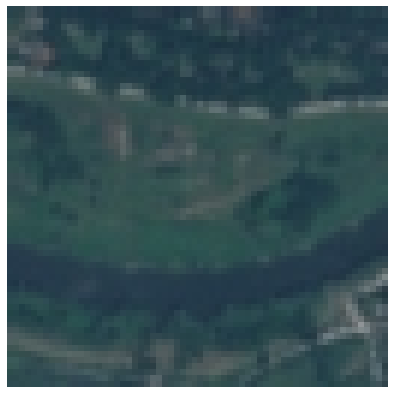

################
LABEL
   River
--------
SOFTMAX
   AnnualCrop:0.00000
   Forest:0.00001
   HerbaceousVegetation:0.00001
   Highway:0.00001
   Industrial:0.00000
   Pasture:0.00000
   PermanentCrop:0.00000
   Residential:0.00001
   River:0.99992
   SeaLake:0.00004


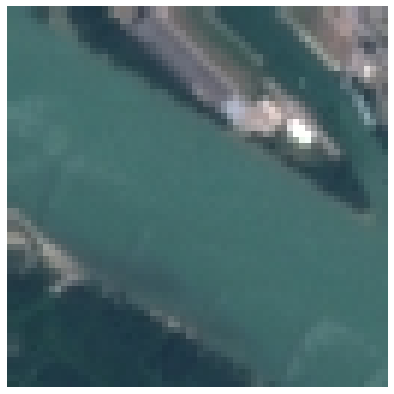

################
LABEL
   Highway
--------
SOFTMAX
   AnnualCrop:0.00001
   Forest:0.00001
   HerbaceousVegetation:0.00000
   Highway:0.99930
   Industrial:0.00001
   Pasture:0.00000
   PermanentCrop:0.00001
   Residential:0.00001
   River:0.00065
   SeaLake:0.00000


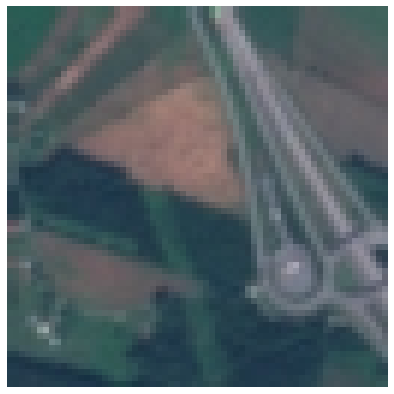

################
LABEL
   Forest
--------
SOFTMAX
   AnnualCrop:0.00000
   Forest:1.00000
   HerbaceousVegetation:0.00000
   Highway:0.00000
   Industrial:0.00000
   Pasture:0.00000
   PermanentCrop:0.00000
   Residential:0.00000
   River:0.00000
   SeaLake:0.00000


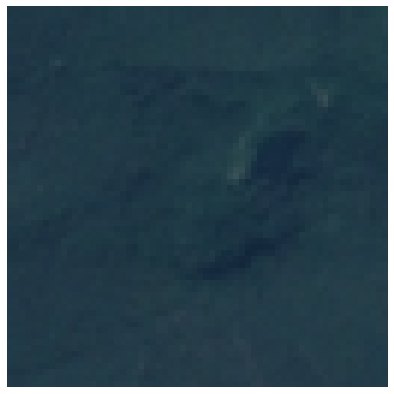

In [26]:
for n in range(10):
    print('################')
    print_sample(n)
    plt.show();
